# Примеры работы с моделью "Анализ текстовых заявок"



In [1]:
from imblearn.over_sampling import RandomOverSampler 
from IPython.display import Image
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score ,recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import pandas as pd
import pymorphy2
import re
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 


In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = set(stopwords.words("russian"))
stop_en = set(stopwords.words("english"))
stop.update(['добрый','день','день'])
stop.update(stop_en)  
ma = pymorphy2.MorphAnalyzer()
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop and len(word)>2 and '@' not in word]
    return " ".join(filtered_words)
def clean_text(text):
    text = text.replace("\\", " ").replace(u"╚", " ").replace(u"╩", " ")
    text = text.lower()
    text = re.sub('!_№\-\s\r\n\s{1,}|\-\s\r\n|\r\n', '', text) #deleting newlines and line-breaks
    text = re.sub('№[.,:;_%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', text) #deleting symbols  
    text = " ".join(ma.parse(word)[0].normal_form for word in text.split())
    text = ' '.join(word for word in text.split() if len(word)>3)
    text = re.sub(r'[0-9]+', '', text)
    text = text.replace("_", " ")
    text = text.replace("!", " ")
    text = text.replace(".", " ")
    text = text.replace(",", " ")
    text = text.replace("№", " ")
    text = text.replace("…", " ")
    text = text.replace(":", " ")
    text = text.replace("&lt;", " ")
    text = text.replace(" pi ", " ")
    text = re.sub(r'\([^()]*\)', '', text)
    text = text.replace("td>", " ")
    text = text.replace("<td>", " ")
    text = text.replace("<tr>", " ")
    text = text.replace("<table>", " ")
    text = text.replace("<", " ")
    text = text.replace(">", " ")
    text = text.replace("<table>", " ")
    text = text.replace("<td>", " ")
    text = text.replace("<tr>", " ")
    text = text.replace("< td>", " ")
    text = text.replace("td>", " ")
    text = text.replace("< tr", " ")
    text = text.replace("< table>", " ")
    text = text.replace("<", " ")
    text = text.replace(">", " ")
    text = text.replace(" tr ", " ")
    text = text.replace(" ru ", " ")
    text = text.replace("{pi}", " ")
    text = text.replace(" тс ", " тсс ")
    text = text.replace("ru&gt", " ")
    text = text.replace(";", " ")
    text = re.sub(r'[\(\)]', ' ', text)
    text = text.replace("?", " ")
    text = text.replace("#", " ")
    text = text.replace("»", " ")
    text = text.replace("«", " ")
    
    
    
    text = remove_stopwords(text)


    return text



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\n.dmitriev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\n.dmitriev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Загрузка данных
df = pd.read_excel(r'C:\Users\n.dmitriev\Downloads\Анализ заявок\training_dataset.xlsx')
df = df.drop(df.columns.difference(['Категория','Текст заявки']), 1)


# очистка текста при помощи функции очистки
df['text'] = df.apply(lambda x: clean_text(x['Текст заявки']), axis=1)
df['text'] = df.apply(lambda x: (x['text'].replace("'", " ")), axis=1)

# кодирование классов 
# понижаем регистр
df['Категория'] = [x.lower() for x in df['Категория']]
le = LabelEncoder()
df['category'] = le.fit_transform(df['Категория'])
df = df[['text', 'category','Категория']]
df.head()

,text,category,Категория
0,коллеги необходимо откорректировать работа дат...,40,оборудование и настройки датчиков - срабатыван...
1,коллеги вложение актуальный дать автомобиль на...,32,оборудование и настройки датчиков - зуммер
2,заявка номер закрытый выполненная просить напр...,41,оборудование и настройки датчиков - тахографы
3,ночи настройка уведомление работать корректно ...,65,уведомления
4,коллега просить выполнить работа включение бли...,46,оборудование и настройки датчиков - фары


In [5]:
vocab_size = 6000 
embedding_dim = 64
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

In [6]:
# окончания заявки часто сожержат мусор, при этом в теме письма часто содержится вся суть
# обрежем текст по параметру максимальной длины
for i in range(len(df.text)):
    df.text[i] = " ".join(df.text[i].split()[:max_length + 1])

# тут формируем переменные для третьей модели
labels = list(df.Категория)

articles = list(df.text)


In [7]:
# создаём тренировочную и тестовую. выборки

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.1, random_state=1)
# считаем сколько у нас классов
num_classes = len(set(df['category']))
num_classes

67

In [8]:
# Сформируем общий словарь для обучения моделей из обучающей и тестовой выборки
vocab_list = df['text'].tolist()
vocab_list[1:2]

['коллеги вложение актуальный дать автомобиль наличие делаваль номер фамилия водителей просьба внести изменение система скаут согласно таблице общий карта прежний видный возвратить авто авто номеров указать фамилия работать сотрудников авто который таблица карте просьба удалить карта отключить зуммер дистанционно также просьба весь автомобиль проверить настройка параметр звучание зуммер скоростной режим некоторый пропали последний выдать авто сначала звучать вообще клиент просить наладить установка зуммерный вновь устанавливать делаваль включать зуммер нужнымделаваль параметр раза постоянно возможно дать нужный заявка установка скаут новый арвать просить подключиться алексей шунина фраза взять переписка также просьба образ автоматически настроить выдавать авто делаваль скаут дать настройка обзванивать каждый пользователь']

# Разделим выборку на обучающую и тестовую и проверим решение для лучшей модели

# тут мы семплируем классы (уравниваем количество случаев каждого класса)

sm = RandomOverSampler()
X_train, y_train = sm.fit_resample(X_train, y_train)




In [9]:
num_classes =  len(set(df['category']))
print('количество классов =',num_classes)

количество классов = 67


In [10]:
## делим выборки
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.1, random_state=1)

## а) пайплайн на SGDClassifier

# при таком наборе параметров GridSearchCV ищет решение довольно долго, я оставил просто на ночь
# подобраный pipline в ячейке ниже, выполнять её не нужно....
# собирается pipline
text_clf = Pipeline(steps=[('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',SGDClassifier(random_state=42, tol=None))])

# для pipline собираются параметры 
# далее их подбирает GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1, 3)],'vect__max_features': (500, 1000,1500,3000,10000),'tfidf__use_idf': (True, False),'clf__loss': ('hinge', 'log_loss', 'log', 'modified_huber'),'clf__alpha': (0.001, 0.01, 0.1, 1,2,3,4,5, 10, 100)}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1) 
gs_clf = gs_clf.fit(X_train, y_train)
predicted  = gs_clf.predict(X_test)




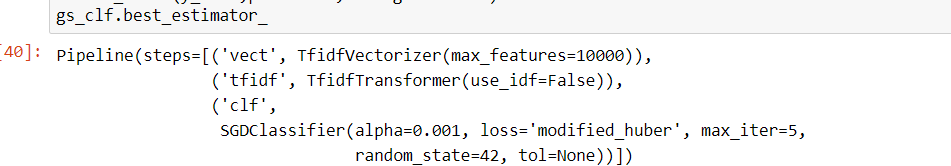

In [25]:
# предсказываем классы лучшим пайплайном

text_clf = Pipeline(steps=[('vect', TfidfVectorizer(max_features=5000)),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf',
                 SGDClassifier( loss='modified_huber', max_iter=1000,
                               random_state=42, tol=None))])

text_clf.fit(X_train, y_train)

predicted  = text_clf.predict(X_test)

print('accuracy =',accuracy_score(y_test,predicted))
print('precision =',precision_score(y_test,predicted,average='macro'))
print('recall =',recall_score(y_test,predicted,average='macro'))

accuracy = 0.7036813518406759
precision = 0.5674285525536948
recall = 0.47718180387921966


# LogisticRegression

In [11]:
def sentiment(v, c):
    model = Pipeline(
        [("vectorizer", v), 
         ("classifier", c)])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    print('accuracy =',accuracy_score(y_test,y_pred))
    print('precision =',precision_score(y_test,y_pred,average='macro'))
    print('recall =',recall_score(y_test,y_pred,average='macro'))

In [12]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1,2,3,4,5, 10, 100]}]


estimator = LogisticRegression()
grid_search = GridSearchCV(estimator = estimator,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
sentiment(TfidfVectorizer(), grid_search)

accuracy = 0.7133373566686784
precision = 0.5639197912729846
recall = 0.4746316717182444


# LSTM


In [13]:
# создаём тренировочную и валидационную выборки

train_articles, validation_articles, train_labels, validation_labels = train_test_split(articles, labels, test_size=0.1, random_state=1)



In [14]:
pd.DataFrame(list(articles)).to_csv(r'C:\Users\n.dmitriev\Downloads\Анализ заявок\learning_set.csv')

In [15]:
# тут обучается токинизатор
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(articles)
word_index = tokenizer.word_index
word_index.keys()

len(word_index)

34278

In [16]:
# токинизатор создаёт векторы заявок (превращает слова в чиселки)


train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type, dtype='float32')

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type,dtype='float32')


In [17]:
# тут мы превращаем текст категории в лейбл категории
encoder = LabelEncoder()
encoder.fit(labels)

train_labels = encoder.transform(train_labels)
validation_labels = encoder.transform(validation_labels)




<AxesSubplot:>

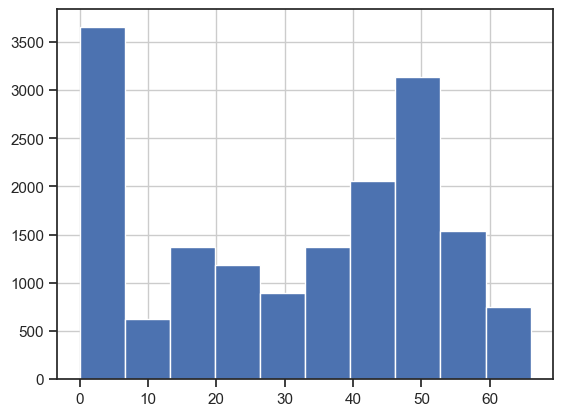

In [18]:
# проверим балланс классов
df['category'].hist()

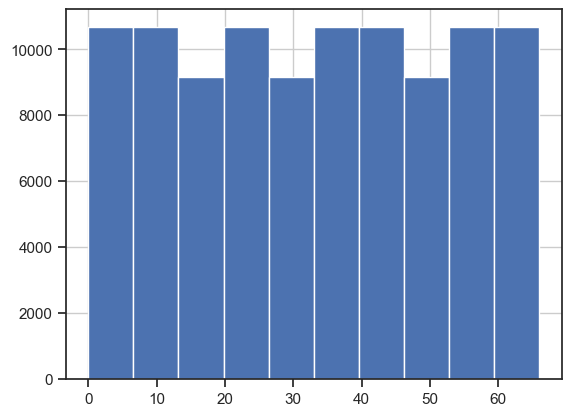

In [19]:

# тут мы семплируем классы (уравниваем количество случаев каждого класса)

sm = RandomOverSampler()
train_padded, train_labels = sm.fit_resample(train_padded, train_labels)

pd.Series(train_labels).hist()

# onehot encoding классов

training_label_seq = keras.utils.to_categorical(train_labels, num_classes)
validation_label_seq = keras.utils.to_categorical(validation_labels, num_classes)



In [20]:
# создаём и собираем модель

model_lstm = Sequential()


model_lstm.add(Embedding(vocab_size, 128, input_length=max_length))
model_lstm.add(tf.keras.layers.SpatialDropout1D(0.5))
model_lstm.add(LSTM(num_classes * 2, return_sequences=True))
model_lstm.add(LSTM(num_classes * 2))
model_lstm.add(Dense(num_classes, activation="softmax"))

model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'AUC'])

model_lstm.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          768000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100, 134)          140968    
                                                                 
 lstm_1 (LSTM)               (None, 134)               144184    
                                                                 
 dense (Dense)               (None, 67)                9045      
                                                                 
Total params: 1,062,197
Trainable params: 1,062,197
Non-trainable params: 0
______________________________________________

Epoch 1/14
205/205 - 283s - loss: 3.5802 - accuracy: 0.1027 - auc: 0.7848 - val_loss: 3.4341 - val_accuracy: 0.0978 - val_auc: 0.8192 - 283s/epoch - 1s/step
Epoch 2/14
205/205 - 286s - loss: 2.8728 - accuracy: 0.2189 - auc: 0.8920 - val_loss: 3.1869 - val_accuracy: 0.1521 - val_auc: 0.8511 - 286s/epoch - 1s/step
Epoch 3/14
205/205 - 286s - loss: 2.3972 - accuracy: 0.3293 - auc: 0.9288 - val_loss: 2.9247 - val_accuracy: 0.2185 - val_auc: 0.8788 - 286s/epoch - 1s/step
Epoch 4/14
205/205 - 286s - loss: 2.0122 - accuracy: 0.4267 - auc: 0.9489 - val_loss: 2.8190 - val_accuracy: 0.2185 - val_auc: 0.8920 - 286s/epoch - 1s/step
Epoch 5/14
205/205 - 289s - loss: 1.6397 - accuracy: 0.5124 - auc: 0.9672 - val_loss: 2.4964 - val_accuracy: 0.3301 - val_auc: 0.9072 - 289s/epoch - 1s/step
Epoch 6/14
205/205 - 298s - loss: 1.2745 - accuracy: 0.6204 - auc: 0.9779 - val_loss: 2.3509 - val_accuracy: 0.3953 - val_auc: 0.9145 - 298s/epoch - 1s/step
Epoch 7/14
205/205 - 313s - loss: 1.0288 - accuracy: 0.699

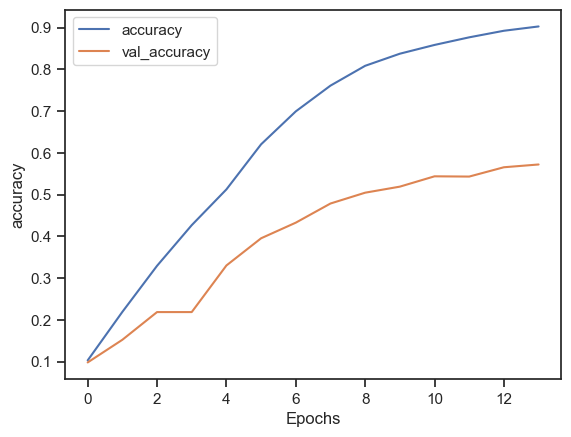

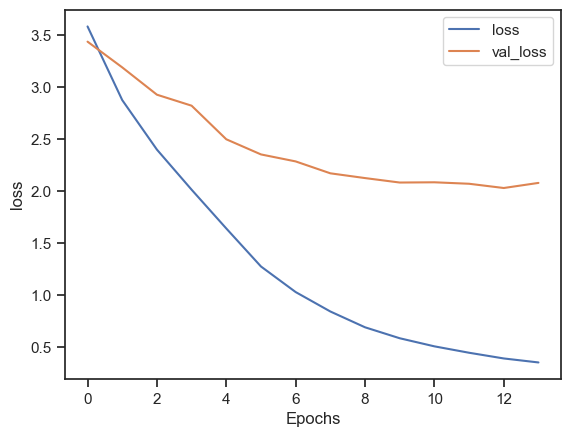

In [21]:
# обучаем модель
num_epochs = 14

history = model_lstm.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq),
                         batch_size=500,
                         validation_split=0.1,
                         shuffle=True,
                         verbose=2
                         )
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")